In [79]:
import numpy as np
import pandas as pd
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import preprocess_string
import gensim.parsing.preprocessing as gsp
from sklearn import utils as skutils
from gensim import utils
from tqdm import tqdm
import multiprocessing
import nltk
import re
from collections import Counter, defaultdict
from nltk.corpus import stopwords


In [80]:
Train_csv = "/Users/sanjayplal/Downloads/drive-download-20220306T114150Z-001/Constraint_English_Train - Sheet1.csv"
Test_csv = "/Users/sanjayplal/Downloads/drive-download-20220306T114150Z-001/english_test_with_labels - Sheet1.csv"
Val_csv = "/Users/sanjayplal/Downloads/drive-download-20220306T114150Z-001/Constraint_English_Val - Sheet1.csv"

In [81]:
df = pd.read_csv(Train_csv)

In [82]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [83]:
def clean_text(
    string: str, 
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=[]):
    

    string = re.sub(r'https?://\S+|www\.\S+', '', string)


    string = re.sub(r'<.*?>', '', string)


    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, " ") 

    string = string.lower()


    string = ' '.join([word for word in string.split() if word not in stop_words])

    string = re.sub(r'\s+', ' ', string).strip()

    return string   

In [84]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [85]:
def normalize(X):
    mean = np.mean(X)
    stddev = np.std(X)
    return (X - mean) * (1 / stddev)

DOC2VEC Transformer

In [86]:
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(remove_emojis(row)).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skutils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [87]:
# way to use doc2vec transformer

# can i train it on a a  larger corpus ?
# look into it.
df_x = df['tweet']
doc2vec = Doc2VecTransformer(vector_size = 2000)
doc2vec_model =  doc2vec.fit(df_x)

100%|██████████████████████████████████| 6420/6420 [00:00<00:00, 6822252.77it/s]


In [88]:
#for TF-IDF 
#unigram
vectorizer = TfidfVectorizer(ngram_range = (1,1))

# # bigram
# vectorizer = TfidfVectorizer(ngram_range = (2,2))

# # unigram + bigram
# vectorizer = TfidfVectorizer(ngram_range = (2,2))


#for Count Vectorizer
# unigram
vectorizer = CountVectorizer(ngram_range = (1,1))


# performance has been best for CountVectorizer

def dataset(pathname, model = 'TF_IDF', default = 'test', vectorizer = vectorizer):
    
    """
    model : TF_IDF or Doc_term or Doc2Vec
    default : train or test
    """
    
    df = pd.read_csv(pathname)

    if(model == 'TF_IDF' or model == 'Doc_term'):
        corpus = []
        for x in df['tweet']:
            corpus.append(clean_text(remove_emojis(x)))
        
        if(default == 'train'):
            X = vectorizer.fit_transform(corpus)
        elif(default == 'test'):
            X = vectorizer.transform(corpus)
        
        Y = np.array([1 if y == 'real' else 0 for y in df['label']])
        
        #print(X.shape, Y.shape)   
        return X, Y
    
    elif(model == 'Doc2Vec'):
        if(default == 'train'):
            X = doc2vec_model.transform(df['tweet'])
        elif(default == 'test'):
            X = doc2vec_model.transform(df['tweet'])

        Y = [1 if y == 'real' else 0 for y in df['label']]
        
        pca = PCA(n_components=500)
        X = pca.fit_transform(X)
        print(X.shape)      
        return X, Y
        
        

# Doc2Vec features

In [89]:
X_train, Y_train = dataset(Train_csv , model = 'Doc2Vec', default = 'train')

/Users/sanjayplal/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


(6420, 500)


In [90]:
from sklearn.linear_model import LogisticRegression

In [91]:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

In [92]:
y_pred = [int(clf.predict(X_train[i, :].reshape(1, -1))) for i in range(6420)]

In [93]:
def accuracy(Y, y):
    acc = 0
    for i in range(len(Y)):
        if Y[i] == y[i]:
            acc +=1
    return acc/len(Y)
            

In [94]:
accuracy(Y_train, y_pred)

0.5336448598130841

In [95]:
X_test, y_test =  dataset(Test_csv, model = 'Doc2Vec' , default = 'test')

/Users/sanjayplal/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


(2140, 500)


In [96]:
ytest_pred = [int(clf.predict(X_test[i, :].reshape(1, -1))) for i in range(len(X_test))]

In [97]:
accuracy(y_test, ytest_pred)

0.530373831775701

# Logistic Regression

In [98]:
X_train, Y_train = dataset(Train_csv , model = 'TF_IDF', default = 'train')
X_test, Y_test =  dataset(Val_csv, model = 'TF_IDF' , default = 'test')

In [99]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
y_pred = [int(clf.predict(X_train[i, :].reshape(1, -1))) for i in range(6420)]

In [100]:
# training accuracy
accuracy(Y_train, y_pred)

0.9947040498442368

In [101]:
ytest_pred = [int(clf.predict(X_test[i, :].reshape(1, -1))) for i in range(2140)]
accuracy(Y_test, ytest_pred)

0.9219626168224299

In [102]:
#tune hyperparameters

# Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier as rfc

# rfc will take huge time to converge for so many features, may be truncated SVD to decrease number of features
# tune hyper-parameters to improve test accuracy
RFC = rfc(random_state=0).fit(X_train, Y_train)
y_pred = [int(RFC.predict(X_train[i, :].reshape(1, -1))) for i in range(6420)]

In [104]:
# training accuracy
# overfitting clearly !, anyway expected
accuracy(Y_train, y_pred)

1.0

In [105]:
ytest_pred = [int(RFC.predict(X_test[i, :].reshape(1, -1))) for i in range(2140)]
accuracy(Y_test, ytest_pred)

0.922429906542056

Grid Search for Random Forest

In [106]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = rfc()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [107]:
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [108]:
grid_search.best_params_
best_grid = grid_search.best_estimator_


In [109]:
y_pred = [int(best_grid.predict(X_train[i, :].reshape(1, -1))) for i in range(6420)]

In [110]:
accuracy(Y_train, y_pred)

0.5233644859813084

# SVMs using various kernels

In [134]:
X_train, Y_train = dataset(Train_csv , model = 'TF_IDF', default = 'train')
X_test, y_test =  dataset(Test_csv, model = 'TF_IDF' , default = 'test')

# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
  
# Building a Support Vector Machine on train data
svc_model = SVC(C= .1, kernel='linear', gamma= 1)
svc_model.fit(X_train, Y_train)
  
prediction = svc_model .predict(X_test)
# check the accuracy on the training set
print(svc_model.score(X_train, Y_train))
print(svc_model.score(X_test, y_test))

print("")

svc_model = SVC(C= .1, kernel='poly', gamma= 1)
svc_model.fit(X_train, Y_train)
  
prediction = svc_model .predict(X_test)
# check the accuracy on the training set
print(svc_model.score(X_train, Y_train))
print(svc_model.score(X_test, y_test))

print("")


svc_model = SVC(C= .1, kernel='sigmoid', gamma= 1)
svc_model.fit(X_train, Y_train)
  
prediction = svc_model .predict(X_test)
# check the accuracy on the training set
print(svc_model.score(X_train, Y_train))
print(svc_model.score(X_test, y_test))

print("")



svc_model = SVC(C= .1, kernel='rbf', gamma= 1)
svc_model.fit(X_train, Y_train)
  
prediction = svc_model .predict(X_test)
# check the accuracy on the training set
print(svc_model.score(X_train, Y_train))
print(svc_model.score(X_test, y_test))

0.979595015576324
0.9186915887850468

0.9998442367601246
0.8504672897196262

0.577570093457944
0.5985981308411215

0.5233644859813084
0.5233644859813084


# Naive Bayes

In [137]:
from sklearn.naive_bayes import GaussianNB

X_train, Y_train = dataset(Train_csv , model = 'Doc2Vec', default = 'train')
X_test, y_test =  dataset(Test_csv, model = 'Doc2Vec' , default = 'test')



gnb = GaussianNB()
gnb.fit(X_train, Y_train)

y_pred = gnb.predict(X_test)

from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

/Users/sanjayplal/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


(6420, 500)


/Users/sanjayplal/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


(2140, 500)
Gaussian Naive Bayes model accuracy(in %): 52.196261682243


# XGBOOST

In [113]:
import xgboost as xgb
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'logloss',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


xgb1 = xgb.XGBClassifier()

xgbmodel = xgb1.fit(X_train, Y_train)
y_pred = [int(xgbmodel.predict(X_train[i, :].reshape(1, -1))) for i in range(6420)]


/Users/sanjayplal/Library/Python/3.8/lib/python/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sanjayplal/Library/Python/3.8/lib/python/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:38] WARNING: /private/var/folders/dd/vfnx3x1x2bvbyk9k4dgpt0jh0000gn/T/pip-install-vrjewc2s/xgboost_8ad6969816624dd090253f6dcc8e8fd5/build/temp.macosx-10.14-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [114]:
# training accuracy
accuracy(Y_train, y_pred)

1.0

In [115]:
ytest_pred = [int(xgbmodel.predict(X_test[i, :].reshape(1, -1))) for i in range(2140)]
accuracy(Y_test, ytest_pred)

0.5112149532710281

# MLPs (ANN)

In [116]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (128, 64) , random_state = 1,  max_iter = 300, learning_rate = 'adaptive')

In [117]:
mlpmodel = mlp.fit(X_train, Y_train)
y_pred = [int(mlpmodel.predict(X_train[i, :].reshape(1, -1))) for i in range(6420)]

/Users/sanjayplal/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [118]:
# training accuracy
accuracy(Y_train, y_pred)

0.7182242990654205

In [119]:
ytest_pred = [int(mlpmodel.predict(X_test[i, :].reshape(1, -1))) for i in range(2140)]
accuracy(Y_test, ytest_pred)

0.5037383177570094

Look into RNNs and CNNS

# KNN

For neighbours  1
0.775233644859813

For neighbours  2
0.7210280373831776

For neighbours  3
0.7691588785046729

For neighbours  4
0.7429906542056075

For neighbours  5
0.766822429906542

For neighbours  6
0.7509345794392523

For neighbours  7
0.7551401869158878

For neighbours  8
0.7397196261682243



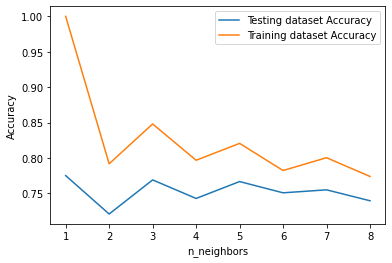

In [136]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

X_train, Y_train = dataset(Train_csv , model = 'TF_IDF', default = 'train')
X_test, y_test =  dataset(Test_csv, model = 'TF_IDF' , default = 'test')

neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    print("For neighbours ", k)
    print(knn.score(X_test, y_test))
    print("")
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, Y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
 
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()